# Intro to AI-driven Science on Supercomputers

## Week 5 Homework

#### Dan Horner (danhorner@berkeley.edu)
---

# ResNet34 Training

## ResNet34 Training on ThetaGPU

Vary the `parallel_threads` and `prefetch_buffer_size` parameters at the top of [train_resnet34.py](train_resnet34.py) and make a table of how the mean image rate changes.



I modified the [submission script](../05train_resnet34_thetagpu_DAH.sh) to point to my branch of the code and ran it on ThetaGPU.

---
Contents of [job log](10109896.keepcobaltlog) from ThetaGPU

---
    Jobid: 10109896
    qsub --mode script -t 60 -q single-gpu -A ALCFAITP -n 1 ./train_resnet34_thetagpu_DAH.sh
    Wed Oct 12 02:46:13 2022 +0000 (UTC) submitted with cwd set to: /lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks
    jobid 10109896 submitted from terminal /dev/pts/14
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Command: '/usr/bin/ssh' 'thetagpu06-gpu0' '/usr/bin/cobalt-launcher.py' '--nf' '/var/tmp/cobalt.10109896' '--jobid' '10109896' '--cwd' '/lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks' '--env' 'COBALT_JOBID=10109896' '/lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks/./train_resnet34_thetagpu_DAH.sh'
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Environment:
    Wed Oct 12 02:46:34 2022 +0000 (UTC) SHELL=/bin/bash
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_NODEFILE=/tmp/tmpk1X0mg
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_PARTNAME=thetagpu06-gpu0
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_JOBID=10109896
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_STARTTIME=1665542781
    Wed Oct 12 02:46:34 2022 +0000 (UTC) LOGNAME=hornerd
    Wed Oct 12 02:46:34 2022 +0000 (UTC) USER=hornerd
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_ENDTIME=1665546381
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_PARTSIZE=1
    Wed Oct 12 02:46:34 2022 +0000 (UTC) HOME=/home/hornerd
    Wed Oct 12 02:46:34 2022 +0000 (UTC) COBALT_JOBSIZE=1
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Info: stdin received from /dev/null
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Info: stdout sent to /lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks/10109896.output
    Wed Oct 12 02:46:34 2022 +0000 (UTC) Info: stderr sent to /lus/swift/home/hornerd/ai-science-training-series/04_modern_neural_networks/10109896.error
    Wed Oct 12 02:46:34 2022 +0000 (UTC) 
    Wed Oct 12 03:46:35 2022 +0000 (UTC) Info: maximum execution time exceeded; initiating job termination
---
(**Note:** I renamed the job log and output files to maintain them in the repo and not mangle my .gitignore)

Inspecting the [job output](10109896.keepoutput) we can see that almost two epochs were able to complete within the 1 hour execution limit; Epoch 0 completed and Epoch 1 completed 4240 of 5004 steps.

## Model Training Performance Charts

### Set Up

In [1]:
import numpy as np
import pandas as pd

import re

# Plotting library
import plotnine as p9
from plotnine import * 
p9.options.figure_size = (15, 12)

import patchworklib as pw

clr_dict = {'Epoch 0': 'red', 'Epoch 1': 'blue'}

# This is the job output file from ThetaGPU (renamed to bypass the .gitignore)
training_report = './10109896.keepoutput'

<Figure size 100x100 with 0 Axes>

### Helper function for plotting

In [2]:
# In order to keep consistency and avoid too much copy-paste of the same plotting set-up, 
# I use a small function that plots column "v", from df (also passes the y-axis label and the colors to use for the Epochs
def base_plot(df, v, ylab, clr_dict):
    pl = (ggplot() 
          + geom_hline(yintercept = 0, colour = 'grey', size = 0.3)
          + geom_line(df, aes(x = 'step', y = v, colour = 'epoch_str'), alpha = 0.3)
          + geom_line(df, aes(x = 'step', y = v + '_roll', colour = 'epoch_str'))
          + scale_x_continuous(name = 'training step')
          + scale_colour_manual(values = clr_dict)
          + scale_y_continuous(name = ylab)
          + theme(
              text = element_text(size = 12),
              legend_position='none',
              legend_title = element_blank(),             
          )
     )
    return(pl)

### Read in and parse the job output, creating a pandas DataFrame holding the values

In [3]:
with open(training_report) as f:
    lines = f.readlines()
li = []
for line in lines:
    if(re.match(r'^Finished step ', line)):
        x = re.search(r'^Finished step (?P<step>\d*) of (?P<tot_steps>\d*) in epoch (?P<epoch>\d*),loss=(?P<loss>[\d.]*), acc=(?P<acc>[\d.]*) \((?P<ips>[\d.]*)', line)
        li.append(x.groupdict())

df = pd.DataFrame(li)

df[['step', 'tot_steps', 'epoch']] = df[['step', 'tot_steps', 'epoch']].astype(int)
df[['loss', 'acc', 'ips']] = df[['loss', 'acc', 'ips']].astype(float)

# Also add a 50-time-step trailing mean value to the DataFrame for plotting
df[['loss_roll', 'acc_roll', 'ips_roll']] = df[['loss', 'acc', 'ips']].rolling(window = 50, min_periods=0).mean()
df['epoch_str'] = 'Epoch ' + df['epoch'].astype(str)

### Training loss

As an initial look, we just plot at the training loss (note the $\log_{10}$ y-axis) across the time-steps we were able to accomplish in the 60-minute execution window.

In this plot and the following charts, the values at each training step are shown as the lighter "jagged" lines, while the smooth darker curve indicates the 50-training-step trailing mean value.

In the first epoch (i.e., "Epoch 0"), the loss decreases very quickly over the initial few training steps: approximately 250 after the first step and 5.4 on the $50^{th}$ step. After the initial steep reduction, the loss decreases steadily (albiet slowly) across the first trainiing epoch until approximately traininig step 4,500. After that step, there is larger improvement per step through the end of the first epoch.

The initial loss for the second epoch ("Epoch 1") again rapidly decreases after the first few training steps, and then steadily, but slowly, decreases until the execution limit is reached at trainining step 4240 of epoch 1. The loss in Epoch 1 is much lower (about half) than it was in Epoch 0. 

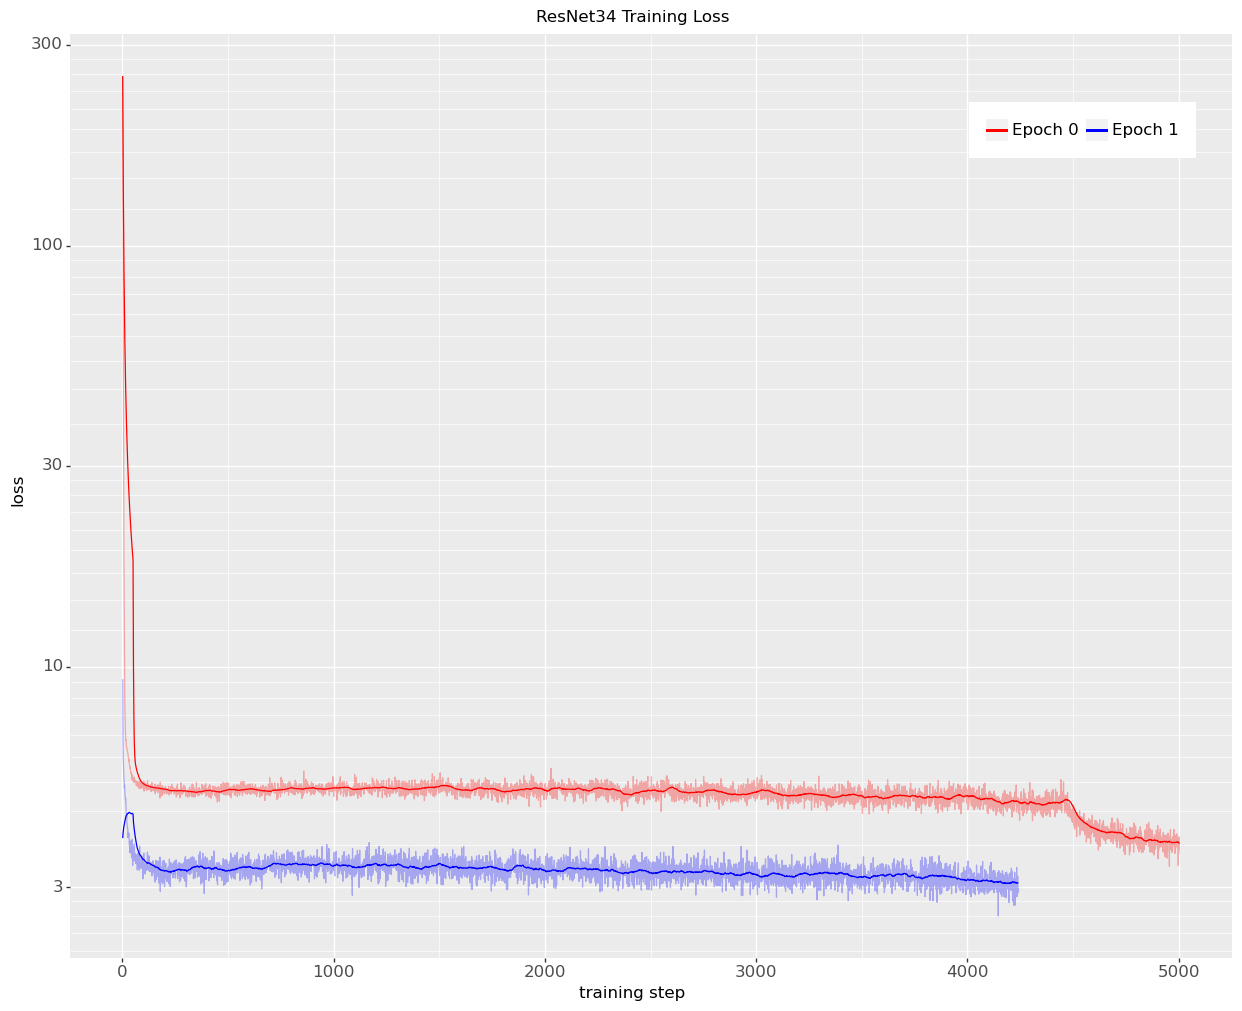

In [4]:
pl = (base_plot(df, 'loss', 'loss', clr_dict) 
      + ggtitle('ResNet34 Training Loss')
      + scale_y_log10(name = 'loss')
      + theme(
          legend_position = (0.8, 0.8)
      )
     )
print(pl)

### Comparing other aspects of training


As a further investigation, we again plot the loss, as well as the accuracy and the image procesessing rate across the training.

Interestingly, the loss decreases slowly during training while the accuracy increases relatively rapidly$-$from essentially zero initially (start of Epoch 0) and acheiving 22% accuracy at the end of the first epoch. During Epoch 1, the accuracy starts off essentially where Epoch 0 ends then increases from 22% to approximately 35% when the trainining terminates.

Additionally, the rate of image procesessing is relaively constant; however there are some osscilations in the image processessing rate, perhaps due to details of the file system on the machine. Also, the rate was slightly higher during Epoch 1 than in Epoch 0.

In [1]:
pl_loss = base_plot(df, 'loss', 'loss', clr_dict) + ggtitle('ResNet34 Training Loss') + coord_cartesian(ylim=(0, 7))
pl_acc = base_plot(df, 'acc', 'accuracy', clr_dict) + ggtitle('ResNet34 Training Accuracy')
pl_ips = base_plot(df, 'ips', 'images per second', clr_dict) + ggtitle('ResNet34 Training Image Procesessing Rate')

pl_loss = pw.load_ggplot(pl_loss, figsize=(7,5))
pl_acc = pw.load_ggplot(pl_acc, figsize=(7,5))
pl_ips = pw.load_ggplot(pl_ips, figsize=(7,5))

pl_pw = ((pl_loss/pl_acc)[pl_acc]|pl_ips)
pl_pw.savefig()

NameError: name 'base_plot' is not defined